# Prosta Regresja Liniowa

W założeniu modelu liniowego podlegającego superwizji definiujemy dane wejściowe (input) i cele (target), zaś
wagi (weights), obciążenia (bias) i dane wyjściowe (output) pozwalamy wyciągnąć samej maszynie.

### 1. Import bibiliotek

In [3]:
import numpy as np
#Poniższe przyda się do wizualizacji w tym wypadku - TensorFlow ma swój TensorBoard do wizualizacji.
import matplotlib.pyplot as plt   # generator grafów - imho coś jak bokeh.
from mpl_toolkits.mplot3d import Axes3D # wizualizacja ww. w 3D.

### 2. Generowanie losowych danych do podstawienia do modelu.

In [4]:
observations = 1000

xs = np.random.uniform(low = -10, high = 10, size =(observations,1)) # funkcja generowania liczb losowych w numpy.
# Od -10 do 10 z równą szansą dla każdej. rozmiar to liczba obserwacji / liczba zmiennych (tutaj 1 zmienna)
zs = np.random.uniform(-10,10,(observations,1)) # ta sama funkcja, druga kolumna i bez opisu wewnątrz.

inputs = np.column_stack((xs,zs)) # Ta funkcja łączy dwie kolumny ze sobą - w ten sposób będzie wyglądać input w TF.
# W tym wypadku mamy do czynienia z matrycą 1000x2.

print(inputs.shape) # Drukuje kształt matrycy. Tutaj użyte jako sanity check.

(1000, 2)


### 3. Utworzenie celów do których ma dążyć maszyna

In [5]:
noise = np.random.uniform(-1,1,(observations,1)) # Generuje 'szum' w danych docelowych. 
# Kiedy zapewniamy maszynie próbkę danych to one nigdy nie są idealne i to reprezentuje ten niewielki szum.

targets = 2*xs - 3*xs + 5 + noise # Tę funkcję ma 'odkryć' maszyna ucząc się z naszych danych. 
# W ten sposób mówimy, że wagi mają mieć 2 i -3 a błąd 5. Jest to wektor 1000x1.

print(targets.shape) # Kolejny sanity check, żeby sprawdzić, czy dobrze zdefiniowaliśmy cele.

(1000, 1)


### 4. Tworzenie grafu 3D dla podglądu danych treningowych

Chodzi tu o to, żeby zobaczyć na wykresie czy występuje tu trend jaki chcieliśmy uzyskać.

In [6]:
def graph_animator(var, observations, targets,):
    # Używamy .reshape żeby przygotować cele pod graf.
    # reshape jest w docsach do numpyego. Jako argumenty przyjmuje wymiary, którymi chcemy opisać obiekt.
    targets = targets.reshape(observations,)

    # Używanie matplotlib - typowa składnia.

    # Zadeklarowanie grafu
    fig = plt.figure()

    # Metoda tworząca graf 3d
    ax = fig.add_subplot(111, projection='3d')

    # Dobór osi
    ax.plot(xs, zs, targets)

    # Dobór nazw osi.
    ax.set_xlabel('xs')
    ax.set_ylabel('zs')
    ax.set_zlabel('Targets')

    # Azymut pozwala oglądać dane z różnych stron. Można się tym pobawić. Np. azim = 0 lub 200.
    ax.view_init(azim=120 + var)

    # Pokaż graf.
    plt.show()
    print(120 + var)

    # Przywracamy poprzedni kształt celom, żeby można ich ponownie użyć do nauki.
    # Równie dobrze można było je przepisać na nową zmienną np. 'targets_plot' i teraz tego nie robić
    # ale warto znać i metodę odwrotną tak na wszelki wypadek. Pytanie co jest mniej zasobochłonne.
    targets = targets.reshape(observations,1)

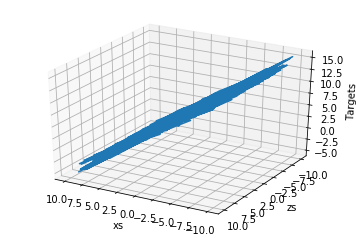

120


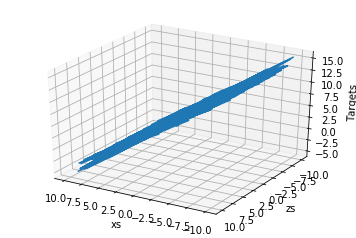

121


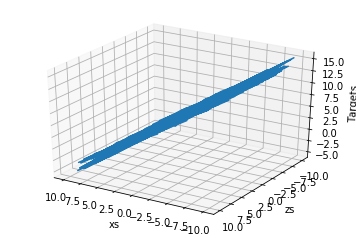

122


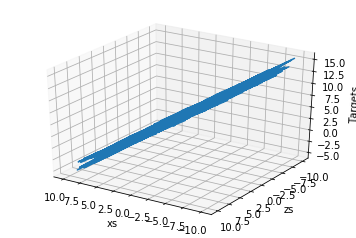

123


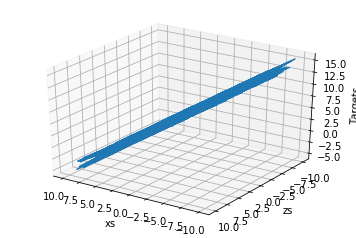

124


In [7]:
# To taka moja mała animacja ad-hoc, bo lubię widzieć co się dzieje w środku, 
# a tak znacznie łatwiej to sobie zwizualizować. :P
# Jak masz przedpotopowy sprzęt jak ja i nie masz GPU (karty graficznej), którą
# dałoby się taki proces przysipieszyć, to polecam nie odpalać navigatora anakondy,
# a najlepiej w ogóle zrezygnować ze środowiska graficznego i poruszać się po systemie przy pomocy basha.
# Naturalnie jeśli Twój komputer nie dostaje zadyszki przy milionie rekordów w bazie, to pewnie
# nie masz się czym przejmować. Ja zbieram teraz na jakiś porządny sprzęt z kartami "tesla" albo na ten procesor
# co to ma być tylko do obsługi SI a jednak bardziej wydajny niż GPU.
for i in range(5):
    graph_animator(i,observations,targets)

### 5. Inicjalizowanie zmiennych

In [8]:
# Zmienna do podstawienia do funkcji generującej losowo startowe wagi i błędy. Na starcie będzie +/- tyle.
# Można się z tym pobawić, ale jak ustawisz za dużo, to algorytm się zawiesi. Lepiej nie ruszać w ogóle.
init_range = 0.1

# Wagi mają wymiar k x m, gdzie k to ilość zmiennych wejściowych (tutaj 2 - x,z), a m to ilość zmiennych wyjściowych
# (tutaj 1 - y). Logicznie matryca wag ma u nas wymiar 2x1.
weights = np.random.uniform(low=-init_range, high=init_range, size=(2, 1))

# Mamy jedno obciążenie, gdyż jest tylko jeden output. Obciążenie to skalar.
biases = np.random.uniform(low=-init_range, high=init_range, size=1)

#Sanity check. Zwraca wagi i obciążenia, żeby mieć ogląd na sposób ich inicjalizacji.
wagi = "wagi: %s" % weights
obci = "obciążenia: %s" % biases
print (wagi)
print (obci)

wagi: [[0.03756897]
 [0.03609647]]
obciążenia: [-0.02622744]


### 6. Ustalanie prędkości uczenia się modelu

Ogólnie przy MNIST od Hindusa używałem 0.01 i strasznie muliło, ale w 30 krokach robiło robotę.
Warto się z tym pobawić. Zwłaszcza przy prostszych modelach, albo mocniejszych maszynach.
Ostatecznie zawsze można przerwać operacje i zmienić wartość na większą a mniej dokładną.

In [9]:
learning_rate = 0.02 # Amerykanie polecają tyle do tego modelu, ale się przy tym nie upierają.